In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sys

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

save_figures = True
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Results/readout_strategies"

sys.path.append("../utils")


In [2]:
data = pd.read_pickle("simulation_data/inbetween_5us_2k.pkl")
dt   = 10
data

,trajectory,initial_state,t,I,Q
0,0,0,0.0,4.254467,-1.054373
1,0,0,10.0,1.300126,1.538154
2,0,0,20.0,0.284344,-1.761994
3,0,0,30.0,2.658563,-3.222678
4,0,0,40.0,-0.367769,-0.597638
...,...,...,...,...,...
496,1999,1,4960.0,0.674118,0.485694
497,1999,1,4970.0,3.060419,1.701387
498,1999,1,4980.0,-1.986689,0.448891
499,1999,1,4990.0,-0.113557,-1.795913


# Data Visuialization and Baseline Prediction

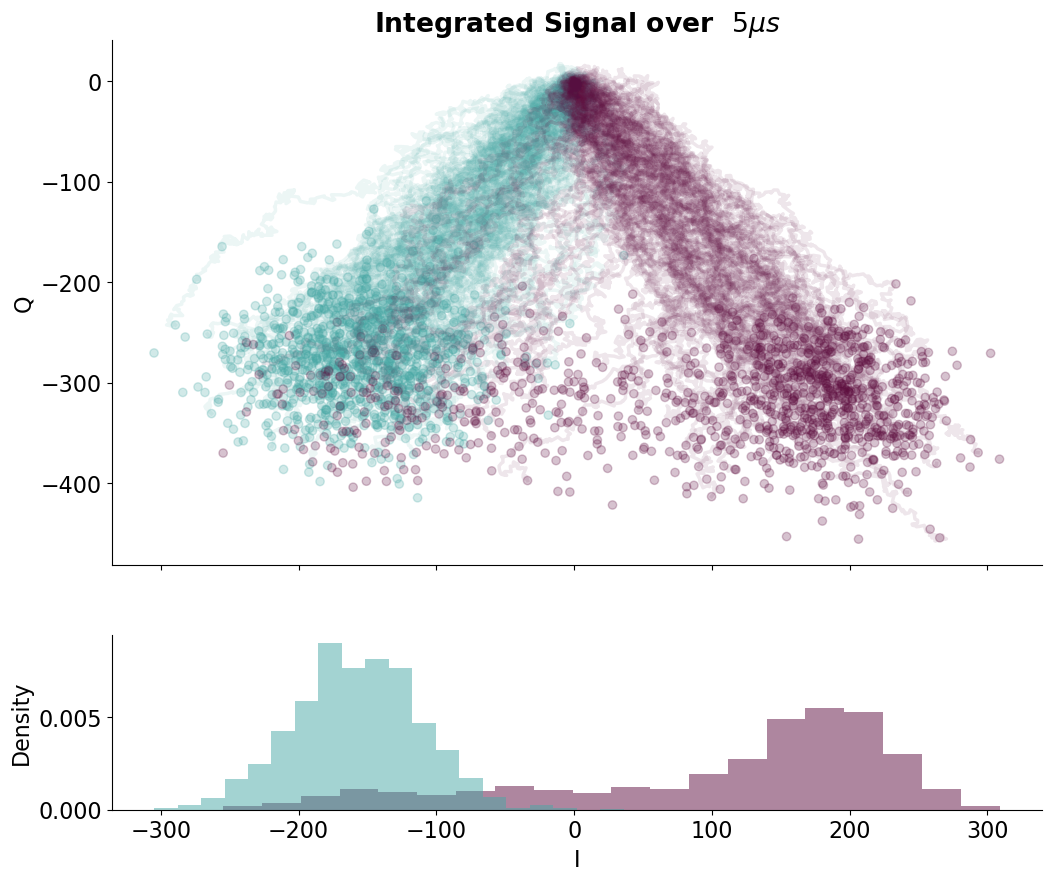

In [3]:
count = 100
fig, ax = plt.subplots(figsize = (12, 10), nrows = 2, gridspec_kw = {"height_ratios": [3, 1]}, sharex = True)

# Just the most simple summing of the data
cumulative_summed = data[np.logical_or(data.trajectory < count, data.trajectory > data.trajectory.max() - count)].groupby("trajectory").apply(lambda x: x.assign(I = x.I.cumsum(), Q = x.Q.cumsum()))
cumulative_summed.initial_state = cumulative_summed.initial_state > 0 
color  = cumulative_summed.groupby("trajectory").initial_state.first().apply(lambda x: "C0" if x else "C1")
for traj in cumulative_summed.trajectory.unique():
    ax[0].plot(cumulative_summed.I[cumulative_summed.trajectory == traj], cumulative_summed.Q[cumulative_summed.trajectory == traj], c = color[traj], alpha = 0.1)

# Complete sum
summed = data.groupby("trajectory").agg({"I": "sum", "Q": "sum", "initial_state": "first"})
summed.initial_state = summed.initial_state > 0
color  = summed.initial_state.apply(lambda x: "C0" if x else "C1")

ax[0].scatter(summed.I, summed.Q, c = color, alpha = 0.25)

ax[1].hist(summed.I[summed.initial_state >= 1], bins = 20, alpha = 0.5, label = "1", density = True);
ax[1].hist(summed.I[summed.initial_state == 0], bins = 20, alpha = 0.5, label = "0", density = True)

ax[0].set(
    title = "Integrated Signal over  $5 \mu s$",
    ylabel = "Q"
)

ax[1].set(
    xlabel = "I",
    ylabel = "Density"
)

fig.savefig(save_path + "/Integrated_signal.png", dpi = 300)

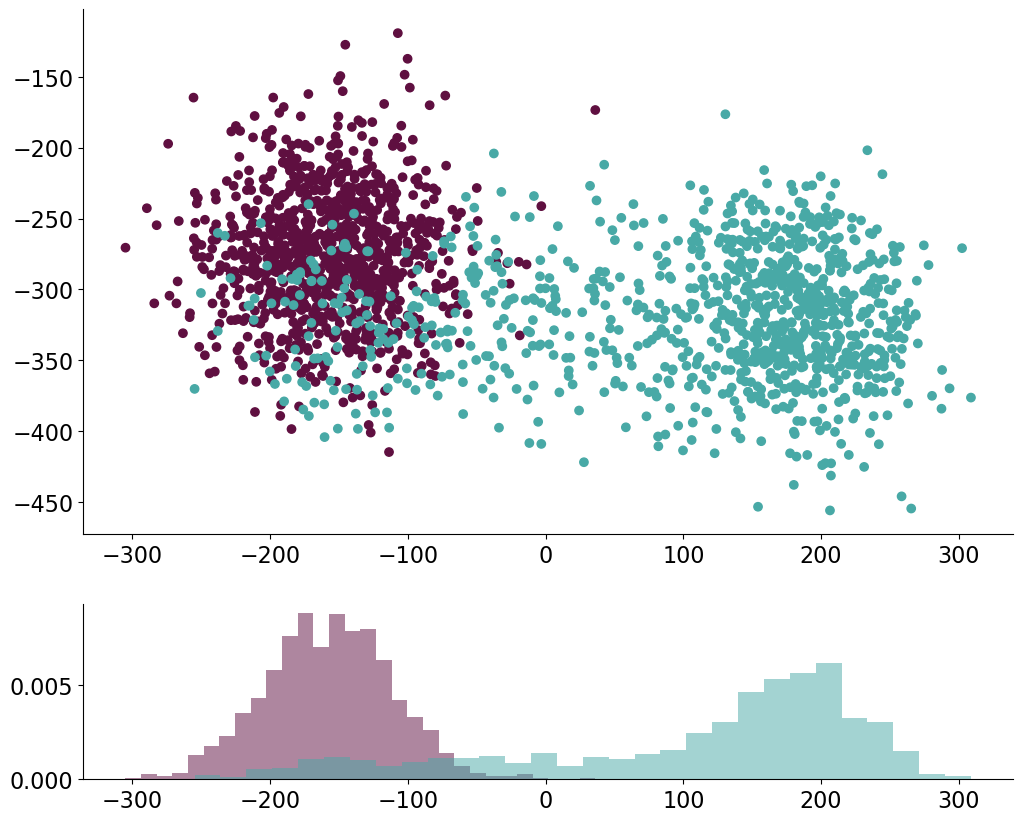

In [4]:
fig, ax = plt.subplots(figsize = (12, 10), nrows = 2, gridspec_kw = {"height_ratios": [3, 1]})

# Just the most simple summing of the data
summed = data.groupby("trajectory").aggregate("sum")
summed.initial_state = summed.initial_state > 0 
color  = summed.initial_state.apply(lambda x: "C0" if x == 0 else "C1")


ax[0].scatter(summed.I, summed.Q, c = color)

ax[1].hist(summed.I[summed.initial_state == 0], bins = 30, alpha = 0.5, label = "0", density = True)
ax[1].hist(summed.I[summed.initial_state >= 1], bins = 30, alpha = 0.5, label = "1", density = True);

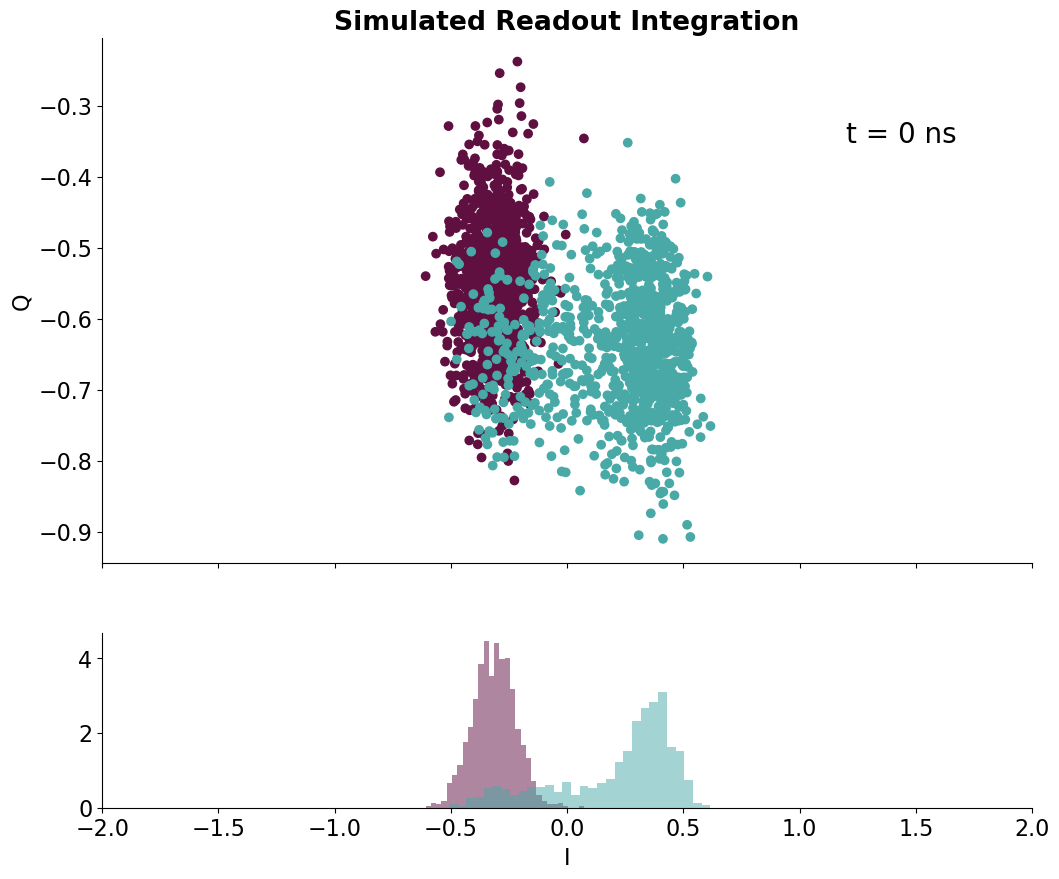

In [5]:
# The same but animated
fig, ax = plt.subplots(figsize = (12, 10), nrows = 2, gridspec_kw = {"height_ratios": [3, 1]}, sharex = True)

summed = data.groupby("trajectory").aggregate("mean")
summed.initial_state = summed.initial_state > 0 
color  = summed.initial_state.apply(lambda x: "C0" if x == 0 else "C1")

scat = ax[0].scatter(summed.I, summed.Q, c = color)

ax[0].set(
    title = "Simulated Readout Integration",
    ylabel = "Q"
)
ax[1].set(
    xlabel = "I"
)

ax[0].text(0.8, 0.8, f"t = 0 ns", transform = ax[0].transAxes, fontsize = 20)

ax[1].hist(summed.I[summed.initial_state == 0], bins = 30, alpha = 0.5, label = "0", density = True)
ax[1].hist(summed.I[summed.initial_state >= 1], bins = 30, alpha = 0.5, label = "1", density = True);

ax[1].set_xlim(-2, 2)
# ax[0].set_ylim

def update(frame):
    ax[0].cla()
    ax[1].cla()

    ax[0].set(
        title = "Simulated Readout Integration",
        ylabel = "Q"
    )
    ax[1].set(
        xlabel = "I",
        ylabel = "Density"
    )



    ax[0].text(0.8, 0.8, f"t = {frame} ns", transform = ax[0].transAxes, fontsize = 20)

    ax[1].set_xlim(-2, 2)
    ax[0].set_ylim(-1.25, 0.25)

    summed = data[data.t < frame].groupby("trajectory").aggregate("mean")
    summed.initial_state = summed.initial_state > 0 
    color  = summed.initial_state.apply(lambda x: "C0" if x == 0 else "C1")

    scat = ax[0].scatter(summed.I, summed.Q, c = color)

    ax[1].hist(summed.I[summed.initial_state == 0], bins = 30, alpha = 0.5, label = "0", density = True)
    ax[1].hist(summed.I[summed.initial_state >= 1], bins = 30, alpha = 0.5, label = "1", density = True);



In [6]:
from IPython.display import HTML 
if False:
    from matplotlib.animation import FuncAnimation
    anim = FuncAnimation(fig, update, frames = np.arange(100, 5100, 25), interval = 1000 / 30)
    anim.save(save_path + "/stochastic_measurements.mp4", writer = "ffmpeg", fps = 30)
    # display(HTML(anim.to_html5_video()))

Text(0.5, 1.0, 'ROC when summing (unweighted) I only')

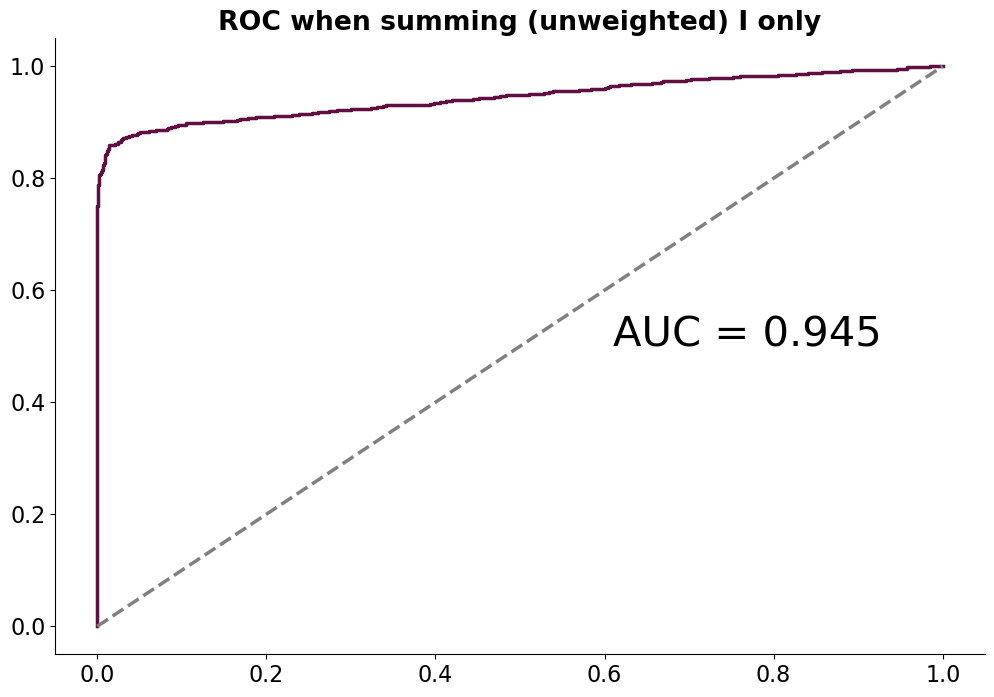

In [7]:
fig, ax = plt.subplots()

from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(summed.initial_state, summed.I)

ax.plot(fpr, tpr, label = "ROC (I)")
ax.plot([0, 1], [0, 1], "--", label = "Random", color = "gray")
ax.text(0.60, 0.50, f"AUC = {roc_auc_score(summed.initial_state, summed.I):.3f}", transform = ax.transAxes, fontsize = 30)
ax.set_title("ROC when summing (unweighted) I only")

Text(0.5, 1.0, 'ROC when summing (unweighted) I & Q - LDA ')

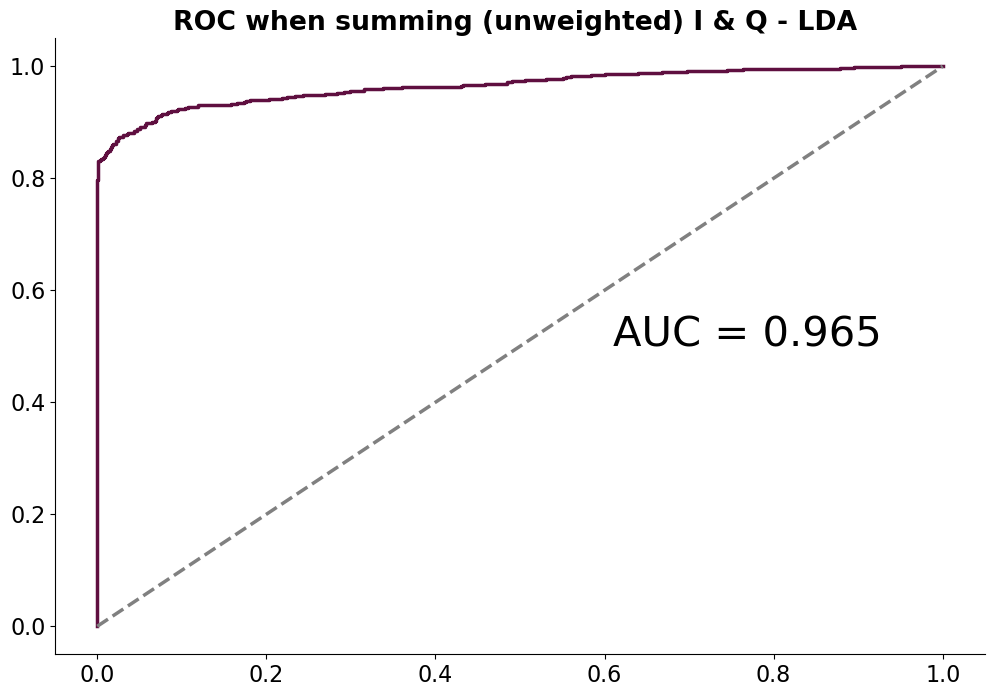

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 

lda = LDA()
transformed = lda.fit_transform(summed[["I", "Q"]], summed.initial_state)

fig, ax = plt.subplots()

fpr, tpr, _ = roc_curve(summed.initial_state, transformed)

ax.plot(fpr, tpr, label = "ROC (I)")
ax.plot([0, 1], [0, 1], "--", label = "Random", color = "gray")
ax.text(0.60, 0.50, f"AUC = {roc_auc_score(summed.initial_state, transformed):.3f}", transform = ax.transAxes, fontsize = 30)
ax.set_title("ROC when summing (unweighted) I & Q - LDA ")


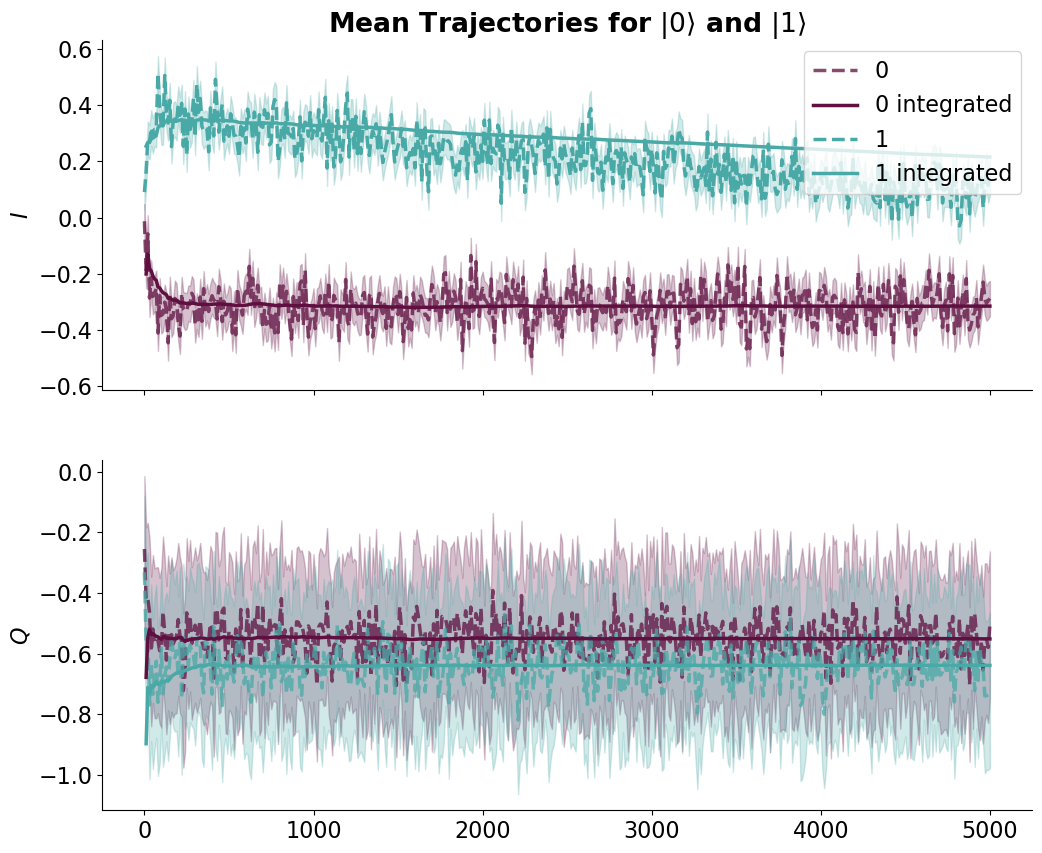

In [9]:
fig, ax = plt.subplots(nrows = 2, figsize = (12, 10), gridspec_kw = {"height_ratios": [1, 1]}, sharex = True)

data0 = data[data.initial_state == 0]
data1 = data[data.initial_state == 1]

I_mean_0 = data0.groupby("t").I.agg("mean")
I_mean_1 = data1.groupby("t").I.agg("mean")

I_mean_0_integrated = I_mean_0.cumsum() / I_mean_0.index * dt 
I_mean_1_integrated = I_mean_1.cumsum() / I_mean_1.index * dt

I_std_0  = data0.groupby("t").I.agg("std")
I_std_1  = data1.groupby("t").I.agg("std")

Q_mean_0 = data0.groupby("t").Q.agg("mean")
Q_mean_1 = data1.groupby("t").Q.agg("mean")

Q_mean_0_integrated = Q_mean_0.cumsum() / Q_mean_0.index * dt 
Q_mean_1_integrated = Q_mean_1.cumsum() / Q_mean_1.index * dt

Q_std_0  = data0.groupby("t").Q.agg("std")
Q_std_1  = data1.groupby("t").Q.agg("std")

ax[0].set_title(r"Mean Trajectories for $|0\rangle$ and $|1\rangle$")
ax[0].plot(I_mean_0, "--", alpha = 0.75, label = "0")
ax[0].plot(I_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")

ax[0].fill_between(I_mean_0.index, I_mean_0 - I_std_0 / np.sqrt(1000), I_mean_0 + I_std_0 / np.sqrt(1000), alpha = 0.25, color = "C0")
ax[0].fill_between(I_mean_1.index, I_mean_1 - I_std_1 / np.sqrt(1000), I_mean_1 + I_std_1 / np.sqrt(1000), alpha = 0.25, color = "C1")

ax[0].plot(I_mean_1, "--", alpha = 1, label = "1")
ax[0].plot(I_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[0].set_ylabel(r"$I$")


ax[1].plot(Q_mean_0, "--", alpha = .75, label = "0", color = "C0")
ax[1].plot(Q_mean_1, "--", alpha = .75, label = "1", color = "C1")

ax[1].plot(Q_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")
ax[1].plot(Q_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[1].fill_between(Q_mean_0.index, Q_mean_0 - Q_std_0 / 8, Q_mean_0 + Q_std_0 / 8, alpha = 0.25, color = "C0")
ax[1].fill_between(Q_mean_1.index, Q_mean_1 - Q_std_1 / 8, Q_mean_1 + Q_std_1 / 8, alpha = 0.25, color = "C1")

ax[1].set_ylabel(r"$Q$")

ax[0].legend(loc = "upper right")

fig.savefig(save_path + "/mean_trajectories.png", dpi = 300)


## Performance as a function of integration time

In [10]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [11]:
included_times = np.arange(100, 5050, 100)
auc_scores     = []
fidelity_scores = []

for time in tqdm(included_times):
    Q_val = data.groupby("trajectory").apply(lambda x: x.I[x.t < time].mean())
    I_val = data.groupby("trajectory").apply(lambda x: x.Q[x.t < time].mean())

    lda = LDA()
    transformed = lda.fit_transform(np.array([Q_val, I_val]).T, summed.initial_state)

    confusion = confusion_matrix(summed.initial_state, transformed > 0, normalize = "true")
    fidelity_scores.append(1 - (confusion[0, 1] + confusion[1, 0]))

    auc = roc_auc_score(summed.initial_state, transformed)

    auc_scores.append(auc)

auc_scores = np.array(auc_scores)
fidelity_scores = np.array(fidelity_scores)


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


Text(0.15, 0.1, 'Time of max AUC score = 1200 ns')

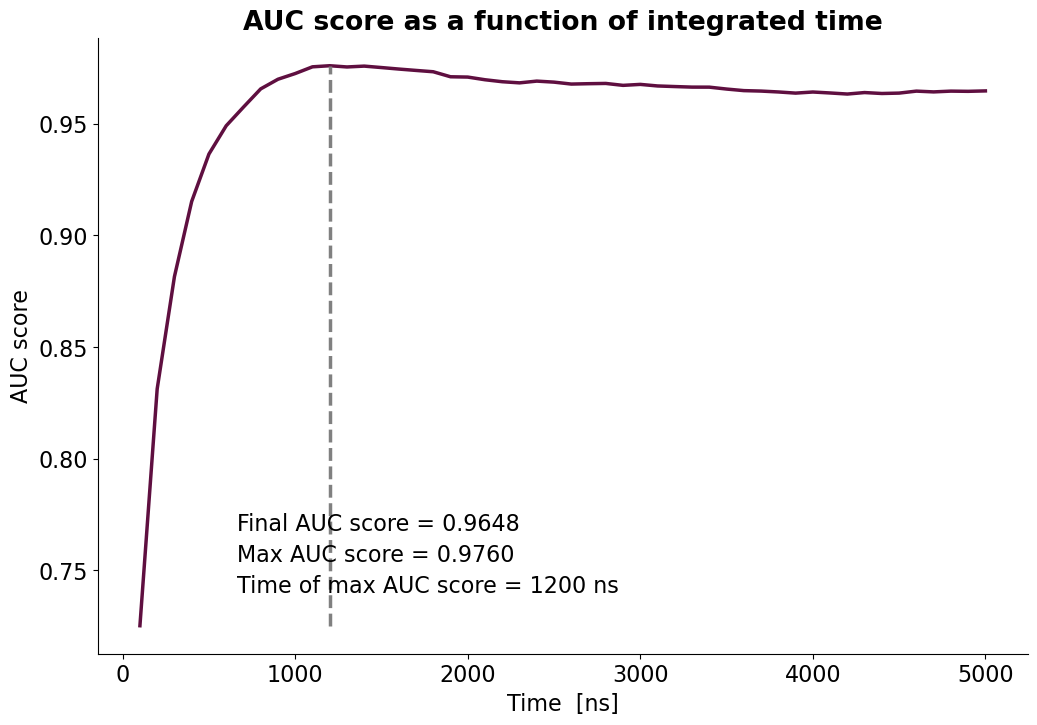

In [12]:
fig, ax = plt.subplots()

ax.set(title = "AUC score as a function of integrated time", xlabel = "Time  [ns]", ylabel = "AUC score")

ax.plot(included_times, auc_scores, label = "AUC score")

# ax.hlines(auc_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[auc_scores.argmax()], auc_scores.min(), auc_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")

ax.text(0.150, 0.20, f"Final AUC score = {auc_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.15, f"Max AUC score = {auc_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.10, f"Time of max AUC score = {included_times[auc_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)

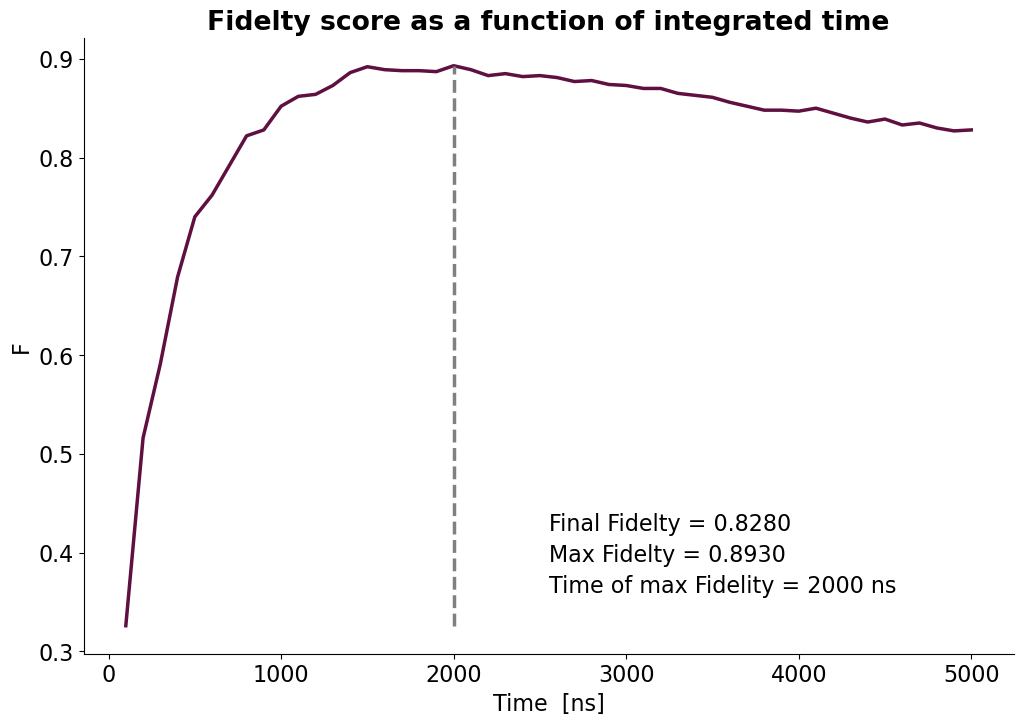

In [13]:
fig, ax = plt.subplots()

ax.set(title = "Fidelty score as a function of integrated time", xlabel = "Time  [ns]", ylabel = "F")

ax.plot(included_times, fidelity_scores, label = "Fidelity")

# ax.hlines(fidelity_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[fidelity_scores.argmax()], fidelity_scores.min(), fidelity_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")

ax.text(0.5, 0.20, f"Final Fidelty = {fidelity_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.5, 0.15, f"Max Fidelty = {fidelity_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.5, 0.10, f"Time of max Fidelity = {included_times[fidelity_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)

fig.savefig(save_path + "/fidelity_over_time_summed.png", dpi = 300)

## Weights by difference in expected IQ 


Weights are made as the difference in the expected trajectory

In [14]:
diff_I = I_mean_1_integrated - I_mean_0_integrated
diff_I.replace(np.inf, 0, inplace = True)
diff_I.fillna(0, inplace = True)

diff_Q = Q_mean_1_integrated - Q_mean_0_integrated
diff_Q.replace(np.inf, 0, inplace = True)
diff_Q.fillna(0, inplace = True)

diff_Q[:100] = 0

In [15]:
weighted_data = data.groupby("trajectory").apply(lambda x: x.assign(I = x.I * diff_I[x.t].values, Q = x.Q * diff_Q[x.t].values))

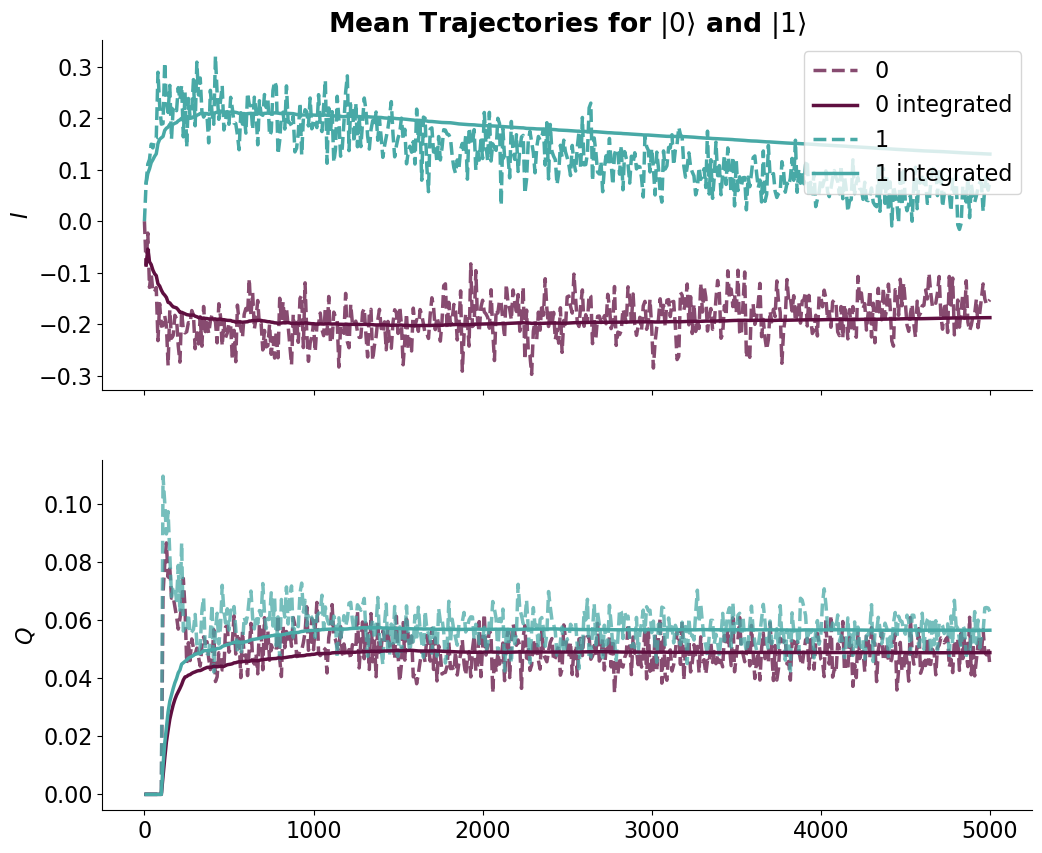

In [ ]:
fig, ax = plt.subplots(nrows = 2, figsize = (12, 10), gridspec_kw = {"height_ratios": [1, 1]}, sharex = True)

data0 = weighted_data[weighted_data.initial_state == 0]
data1 = weighted_data[weighted_data.initial_state == 1]

I_mean_0 = data0.groupby("t").I.agg("mean")
I_mean_1 = data1.groupby("t").I.agg("mean")

I_mean_0_integrated = I_mean_0.cumsum() / I_mean_0.index * dt 
I_mean_1_integrated = I_mean_1.cumsum() / I_mean_1.index * dt

I_std_0  = data0.groupby("t").I.agg("std")
I_std_1  = data1.groupby("t").I.agg("std")

Q_mean_0 = data0.groupby("t").Q.agg("mean")
Q_mean_1 = data1.groupby("t").Q.agg("mean")

Q_mean_0_integrated = Q_mean_0.cumsum() / Q_mean_0.index * dt 
Q_mean_1_integrated = Q_mean_1.cumsum() / Q_mean_1.index * dt

Q_std_0  = data0.groupby("t").Q.agg("std")
Q_std_1  = data1.groupby("t").Q.agg("std")

ax[0].set_title(r"Mean Trajectories for $|0\rangle$ and $|1\rangle$")
ax[0].plot(I_mean_0, "--", alpha = 0.75, label = "0")
ax[0].plot(I_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")

ax[0].plot(I_mean_1, "--", alpha = 1, label = "1")
ax[0].plot(I_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[0].set_ylabel(r"$I$")


ax[1].plot(Q_mean_0, "--", alpha = .75, label = "0", color = "C0")
ax[1].plot(Q_mean_1, "--", alpha = .75, label = "1", color = "C1")

ax[1].plot(Q_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")
ax[1].plot(Q_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[1].set_ylabel(r"$Q$")

ax[0].legend(loc = "upper right")


In [18]:
included_times = np.arange(100, 5100, 100)
auc_scores     = []
fidelity_scores = []

for time in tqdm(included_times):
    Q_val = weighted_data.groupby("trajectory").apply(lambda x: x.I[x.t < time].mean())
    I_val = weighted_data.groupby("trajectory").apply(lambda x: x.Q[x.t < time].mean())

    lda = LDA()
    transformed = lda.fit_transform(np.array([Q_val, I_val]).T, summed.initial_state)

    auc = roc_auc_score(summed.initial_state, transformed)
    auc_scores.append(auc)

    confusion = confusion_matrix(summed.initial_state, transformed > 0, normalize = "true")
    fidelity_scores.append(1 - (confusion[0, 1] + confusion[1, 0]))

auc_scores = np.array(auc_scores)
fidelity_scores = np.array(fidelity_scores)


100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


Text(0.15, 0.1, 'Time of max AUC score = 1200 ns')

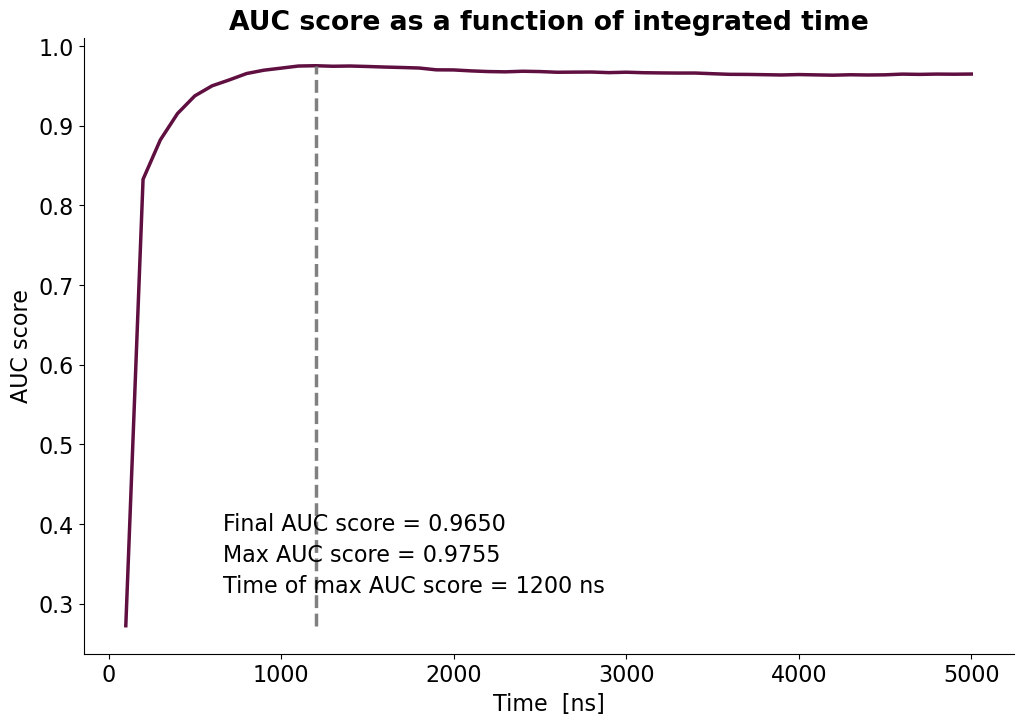

In [19]:
fig, ax = plt.subplots()

ax.set(title = "AUC score as a function of integrated time", xlabel = "Time  [ns]", ylabel = "AUC score")

ax.plot(included_times, auc_scores, label = "AUC score")

# ax.hlines(auc_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[auc_scores.argmax()], auc_scores.min(), auc_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")


ax.text(0.150, 0.20, f"Final AUC score = {auc_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.15, f"Max AUC score = {auc_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.10, f"Time of max AUC score = {included_times[auc_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)

Text(0.15, 0.1, 'Time of max Fidelity = 2000 ns')

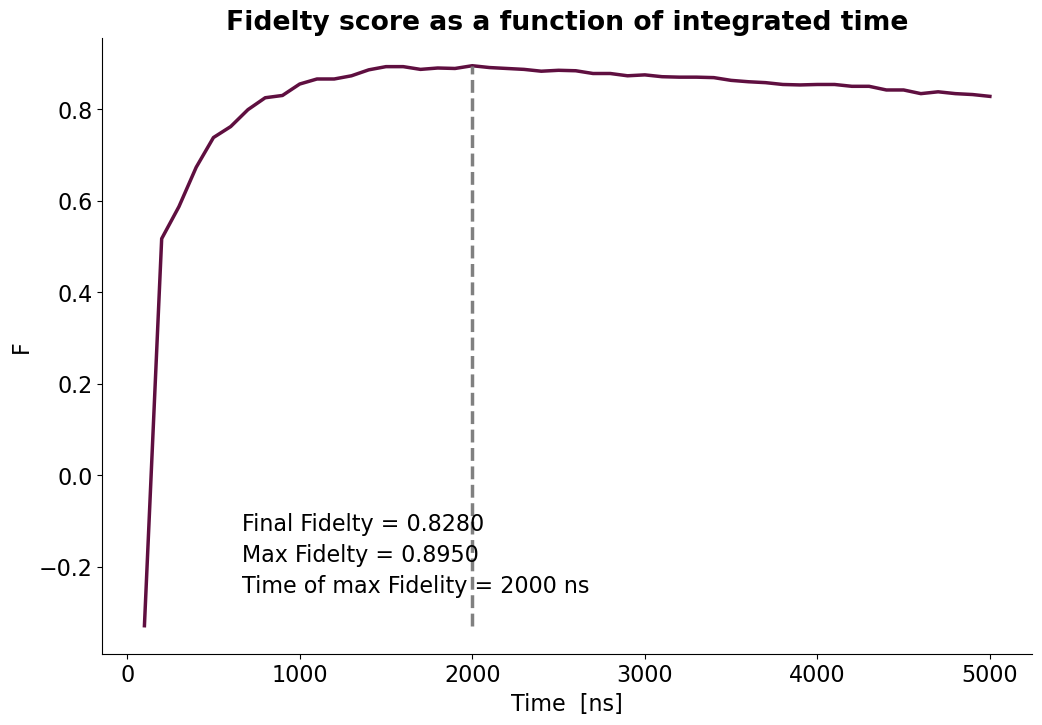

In [20]:
fig, ax = plt.subplots()

ax.set(title = "Fidelty score as a function of integrated time", xlabel = "Time  [ns]", ylabel = "F")

ax.plot(included_times, fidelity_scores, label = "Fidelity")

# ax.hlines(fidelity_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[fidelity_scores.argmax()], fidelity_scores.min(), fidelity_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")

ax.text(0.150, 0.20, f"Final Fidelty = {fidelity_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.15, f"Max Fidelty = {fidelity_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.10, f"Time of max Fidelity = {included_times[fidelity_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)

# Treating like a Fit

All points have a normal distribution around the expected trajectory with uncertainty $\sigma = 1 / \sqrt{\eta}$ where $\eta$ for this simulation is $0.75$. We can calculate the log-likelihood as a chi-square between the expected trajectory and the actual trajectory.

In [21]:
from sklearn.model_selection import train_test_split

traj_train, traj_test = train_test_split(data.trajectory.unique(), test_size = 0.2, random_state = 42)

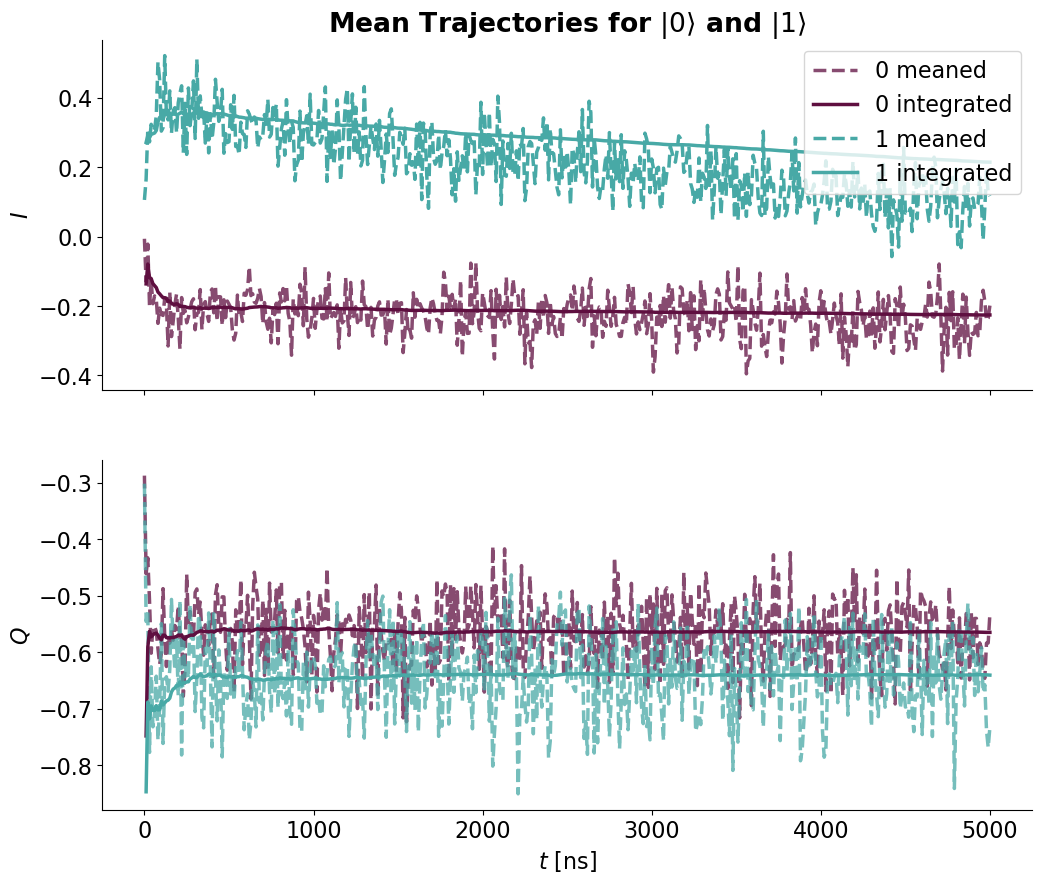

In [35]:
fig, ax = plt.subplots(nrows = 2, figsize = (12, 10), gridspec_kw = {"height_ratios": [1, 1]}, sharex = True)

data0 = data[data.trajectory.isin(traj_train) & data.initial_state == 0]
data1 = data[data.trajectory.isin(traj_train) & data.initial_state == 1]

I_mean_0 = data0.groupby("t").I.agg("mean")
I_mean_1 = data1.groupby("t").I.agg("mean")

I_mean_0_integrated = I_mean_0.cumsum() / I_mean_0.index * dt 
I_mean_1_integrated = I_mean_1.cumsum() / I_mean_1.index * dt

I_std_0  = data0.groupby("t").I.agg("std")
I_std_1  = data1.groupby("t").I.agg("std")

Q_mean_0 = data0.groupby("t").Q.agg("mean")
Q_mean_1 = data1.groupby("t").Q.agg("mean")

Q_mean_0_integrated = Q_mean_0.cumsum() / Q_mean_0.index * dt 
Q_mean_1_integrated = Q_mean_1.cumsum() / Q_mean_1.index * dt

Q_std_0  = data0.groupby("t").Q.agg("std")
Q_std_1  = data1.groupby("t").Q.agg("std")

ax[0].set_title(r"Mean Trajectories for $|0\rangle$ and $|1\rangle$")
ax[0].plot(I_mean_0, "--", alpha = 0.75, label = "0 meaned")
ax[0].plot(I_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")

ax[0].plot(I_mean_1, "--", alpha = 1, label = "1 meaned")
ax[0].plot(I_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[0].set_ylabel(r"$I$")


ax[1].plot(Q_mean_0, "--", alpha = .75, label = "0", color = "C0")
ax[1].plot(Q_mean_1, "--", alpha = .75, label = "1", color = "C1")

ax[1].plot(Q_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")
ax[1].plot(Q_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[1].set_ylabel(r"$Q$")

ax[0].legend(loc = "upper right")

ax[1].set_xlabel(r"$t$ [ns]")

fig.savefig(save_path + "/mean_trajectories.png", dpi = 300)


In [23]:
chi2_0 = data[data.trajectory.isin(traj_test)].groupby("trajectory").apply(lambda x: x.assign(I = x.I - I_mean_0[x.t].values, Q = x.Q - Q_mean_0[x.t].values))
chi2_1 = data[data.trajectory.isin(traj_test)].groupby("trajectory").apply(lambda x: x.assign(I = x.I - I_mean_1[x.t].values, Q = x.Q - Q_mean_1[x.t].values))


In [24]:
chi2_0.describe()

,trajectory,initial_state,t,I,Q
count,200400.000000,200400.000000,200400.000000,200400.000000,200400.000000
mean,1011.992500,0.502500,2500.000000,0.178521,-0.024597
std,590.447425,0.499995,1446.263152,2.029484,2.001297
min,23.000000,0.000000,0.000000,-8.941835,-9.292226
25%,481.500000,0.000000,1250.000000,-1.189481,-1.372847
50%,1015.500000,1.000000,2500.000000,0.183161,-0.024864
75%,1552.000000,1.000000,3750.000000,1.549724,1.324816
max,1990.000000,1.000000,5000.000000,9.036600,8.950602


In [25]:
chi2_0.I = chi2_0.I ** 2 #/ I_std_0[chi2_0.t].values ** 2
chi2_1.I = chi2_1.I ** 2 #/ I_std_1[chi2_1.t].values ** 2

chi2_0.Q = chi2_0.Q ** 2 #/ Q_std_0[chi2_0.t].values ** 2
chi2_1.Q = chi2_1.Q ** 2 #/ Q_std_1[chi2_1.t].values ** 2

In [26]:
chi2_0.describe()

,trajectory,initial_state,t,I,Q
count,200400.000000,200400.000000,200400.000000,2.004000e+05,2.004000e+05
mean,1011.992500,0.502500,2500.000000,4.150654e+00,4.005773e+00
std,590.447425,0.499995,1446.263152,5.888524e+00,5.639282e+00
min,23.000000,0.000000,0.000000,6.038158e-14,1.490845e-09
25%,481.500000,0.000000,1250.000000,4.226748e-01,4.062785e-01
50%,1015.500000,1.000000,2500.000000,1.886387e+00,1.819259e+00
75%,1552.000000,1.000000,3750.000000,5.498855e+00,5.301733e+00
max,1990.000000,1.000000,5000.000000,8.166013e+01,8.634547e+01


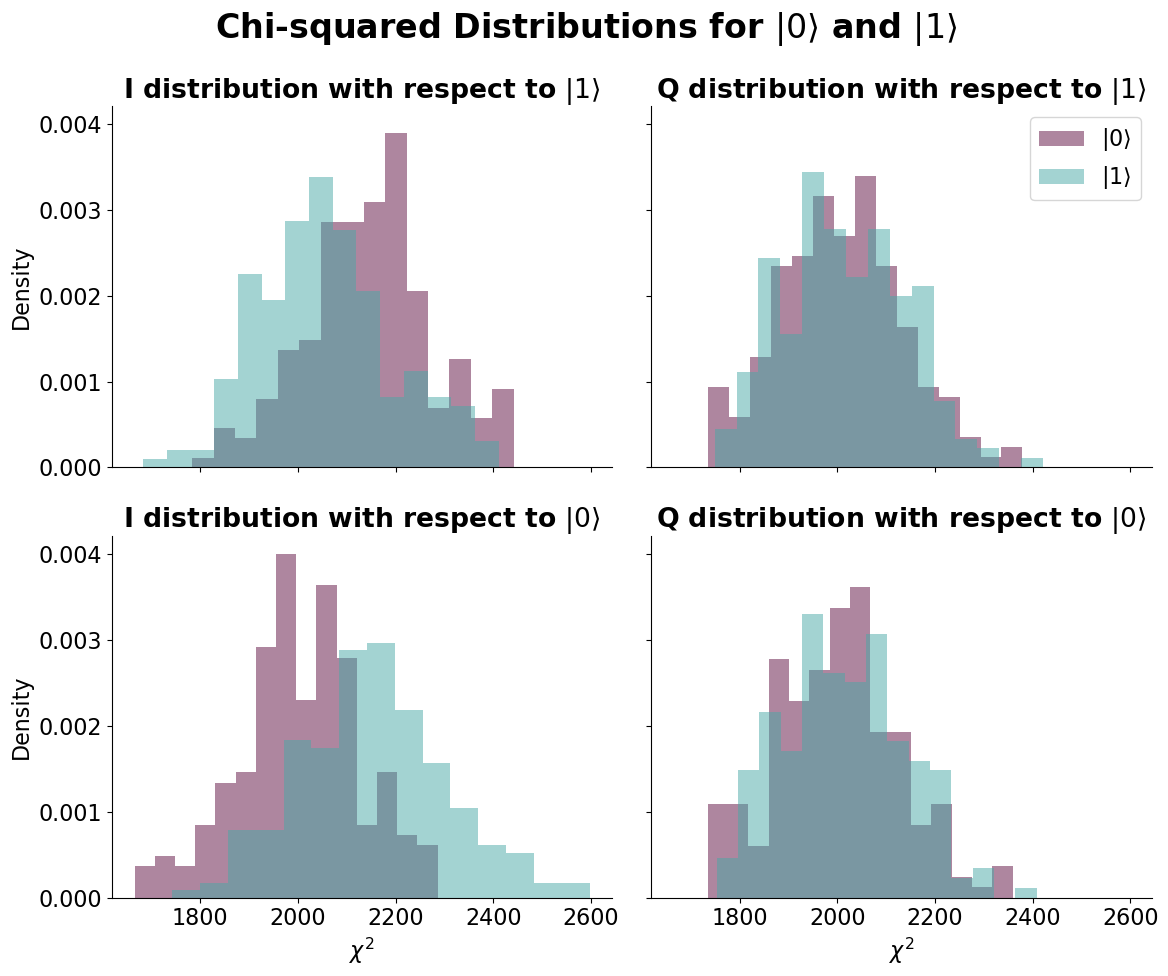

In [27]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, sharex = True, sharey = True, figsize = (12, 10))

fig.suptitle(r"Chi-squared Distributions for $|0\rangle$ and $|1\rangle$", fontsize = 24, fontweight = "bold")

ax[0, 0].hist(chi2_1[chi2_1["initial_state"] == 0].groupby("trajectory").I.agg("sum"), bins = 15, density = True, alpha = 0.5)
ax[0, 0].hist(chi2_1[chi2_1["initial_state"] == 1].groupby("trajectory").I.agg("sum"), bins = 15, density = True, alpha = 0.5)

ax[0, 0].set(
    title = r"I distribution with respect to $|1\rangle$",
    ylabel = "Density"
)

ax[0, 1].hist(chi2_1[chi2_1["initial_state"] == 0].groupby("trajectory").Q.agg("sum"), bins = 15, density = True, alpha = 0.5, label = r"$|0\rangle$")
ax[0, 1].hist(chi2_1[chi2_1["initial_state"] == 1].groupby("trajectory").Q.agg("sum"), bins = 15, density = True, alpha = 0.5, label = r"$|1\rangle$")

ax[0, 1].set(
    title = r"Q distribution with respect to $|1\rangle$",
)

ax[1, 0].hist(chi2_0[chi2_0["initial_state"] == 0].groupby("trajectory").I.agg("sum"), bins = 15, density = True, alpha = 0.5)
ax[1, 0].hist(chi2_0[chi2_0["initial_state"] == 1].groupby("trajectory").I.agg("sum"), bins = 15, density = True, alpha = 0.5)

ax[1, 0].set(
    title = r"I distribution with respect to $|0\rangle$",
    ylabel = "Density",
    xlabel = r"$\chi^2$"
)

ax[1, 1].hist(chi2_0[chi2_0["initial_state"] == 0].groupby("trajectory").Q.agg("sum"), bins = 15, density = True, alpha = 0.5)
ax[1, 1].hist(chi2_0[chi2_0["initial_state"] == 1].groupby("trajectory").Q.agg("sum"), bins = 15, density = True, alpha = 0.5);

ax[1, 1].set(
    title = r"Q distribution with respect to $|0\rangle$",
    xlabel = r"$\chi^2$"
)


ax[0, 1].legend()
fig.tight_layout()

fig.savefig(save_path + "/chi2_distributions.png", dpi = 300)

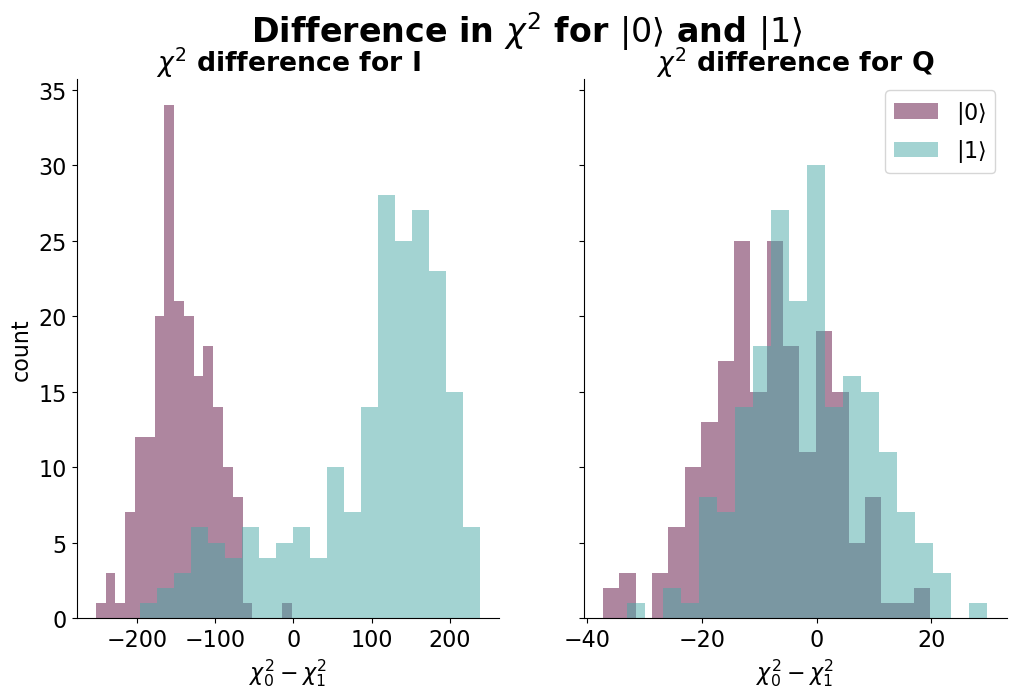

In [54]:
# Perform plots for difference between chi2 for 0 and 1
fig, ax = plt.subplots(ncols = 2, sharey = True, figsize = (12, 7))

fig.suptitle(r"Difference in $\chi^2$ for $|0\rangle$ and $|1\rangle$", fontsize = 24, fontweight = "bold")

ax[0].set(
    title = r"$\chi^2$ difference for I",
    ylabel = "count",
    xlabel = r"$\chi_0^2 - \chi_1^2$"
)

ax[1].set(
    title = r"$\chi^2$ difference for Q",
    xlabel = r"$\chi_0^2 - \chi_1^2$"
)

chi2_I_0 =  (chi2_0[chi2_0["initial_state"] == 0].groupby("trajectory").I.agg("sum")) - (chi2_1[chi2_1["initial_state"] == 0].groupby("trajectory").I.agg("sum"))
chi2_I_1 =  (chi2_0[chi2_0["initial_state"] == 1].groupby("trajectory").I.agg("sum")) - (chi2_1[chi2_1["initial_state"] == 1].groupby("trajectory").I.agg("sum"))

chi2_Q_0 =  (chi2_0[chi2_0["initial_state"] == 0].groupby("trajectory").Q.agg("sum")) - (chi2_1[chi2_1["initial_state"] == 0].groupby("trajectory").Q.agg("sum"))
chi2_Q_1 =  (chi2_0[chi2_0["initial_state"] == 1].groupby("trajectory").Q.agg("sum")) - (chi2_1[chi2_1["initial_state"] == 1].groupby("trajectory").Q.agg("sum"))

#
ax[0].hist(chi2_I_0, bins = 20, alpha = 0.5)
ax[0].hist(chi2_I_1, bins = 20, alpha = 0.5)

ax[1].hist(chi2_Q_0, bins = 20, alpha = 0.5, label = r"$|0\rangle$")
ax[1].hist(chi2_Q_1, bins = 20, alpha = 0.5, label = r"$|1\rangle$")

ax[1].legend()


fig.savefig(save_path + "/chi2_differences.png", dpi = 300)

In [28]:
chi2_score_0_I = chi2_0.groupby("trajectory").I.agg("sum")
chi2_score_0_Q = chi2_0.groupby("trajectory").Q.agg("sum")
chi2_score_1_I = chi2_1.groupby("trajectory").I.agg("sum")
chi2_score_1_Q = chi2_1.groupby("trajectory").Q.agg("sum")

In [29]:
labels = chi2_0.groupby("trajectory").initial_state.first()

roc_auc_score(labels, chi2_score_0_I - chi2_score_1_I), roc_auc_score(labels, chi2_score_0_Q - chi2_score_1_Q)

(0.9689242231055777, 0.6769419235480888)

In [30]:
included_times = np.arange(100, 5100, 100)
auc_scores     = []
fidelity_scores = []

for time in tqdm(included_times):

    chi2_score_0_I = chi2_0[chi2_0.t <= time].groupby("trajectory").I.agg("sum")
    chi2_score_0_Q = chi2_0[chi2_0.t <= time].groupby("trajectory").Q.agg("sum")
    chi2_score_1_I = chi2_1[chi2_1.t <= time].groupby("trajectory").I.agg("sum")
    chi2_score_1_Q = chi2_1[chi2_1.t <= time].groupby("trajectory").Q.agg("sum")

    Q_val = (chi2_score_0_Q - chi2_score_1_Q)
    I_val = (chi2_score_0_I - chi2_score_1_I) 
    
    lda = LDA()
    transformed = lda.fit_transform(np.array([Q_val, I_val]).T, labels)

    auc = roc_auc_score(labels, transformed)
    auc_scores.append(auc)

    confusion = confusion_matrix(labels, transformed > 0, normalize = "true" )
    fidelity_scores.append(1 - (confusion[0, 1] + confusion[1, 0]))

auc_scores = np.array(auc_scores)
fidelity_scores = np.array(fidelity_scores)


100%|██████████| 50/50 [00:02<00:00, 22.86it/s]


<AxesSubplot:>

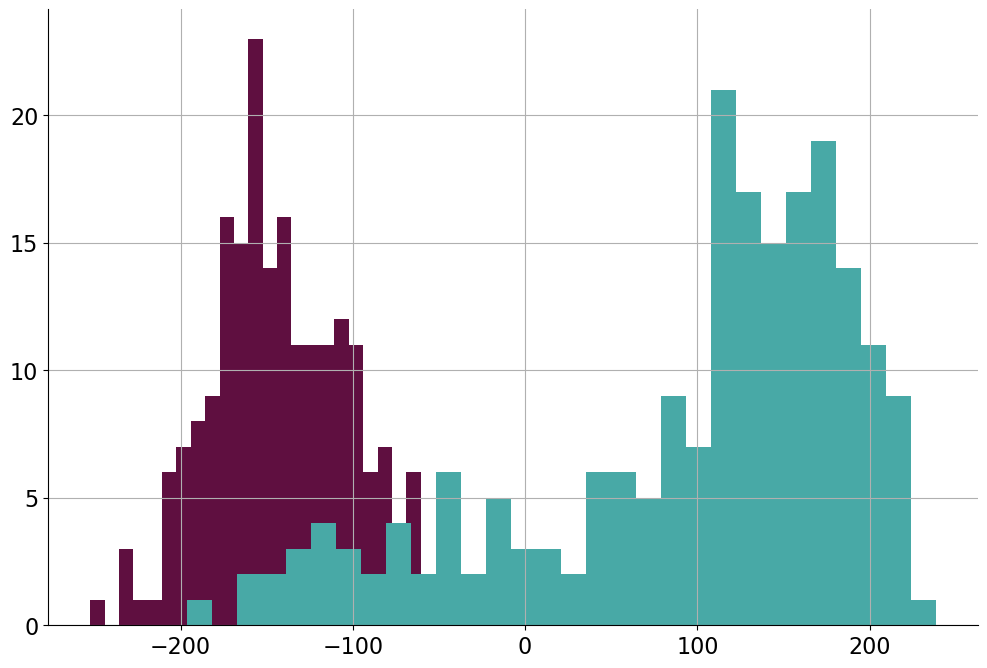

In [31]:
I_val[labels == 0].hist(bins = 30)
I_val[labels == 1].hist(bins = 30)

Text(0.15, 0.1, 'Time of max AUC score = 1700 ns')

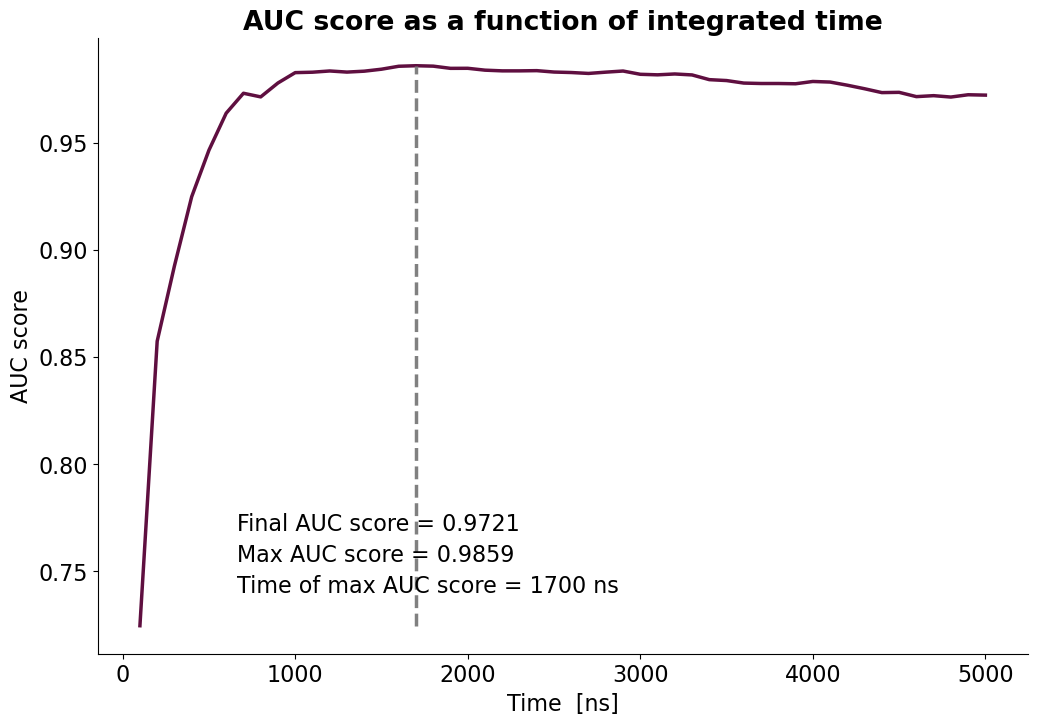

In [32]:
fig, ax = plt.subplots()

ax.set(title = "AUC score as a function of integrated time", xlabel = "Time  [ns]", ylabel = "AUC score")

ax.plot(included_times, auc_scores, label = "AUC score")

# ax.hlines(auc_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[auc_scores.argmax()], auc_scores.min(), auc_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")

ax.text(0.150, 0.20, f"Final AUC score = {auc_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.15, f"Max AUC score = {auc_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.10, f"Time of max AUC score = {included_times[auc_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)



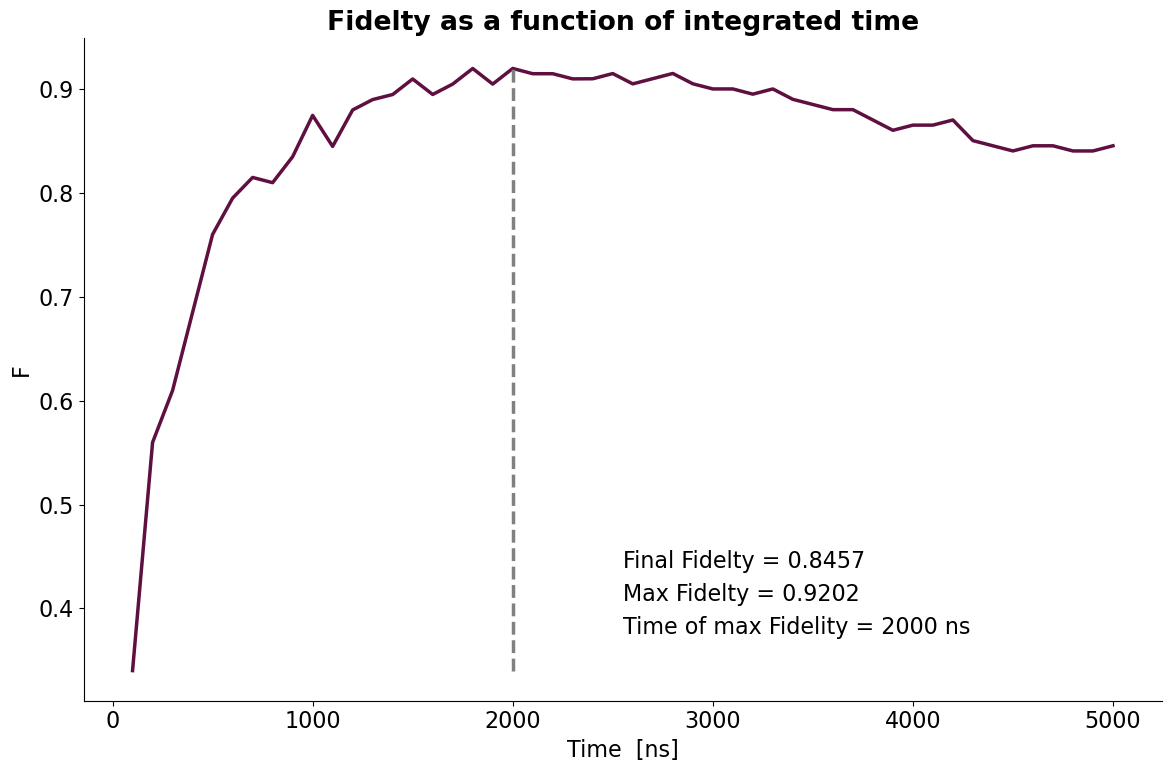

In [33]:
fig, ax = plt.subplots()

ax.set(title = "Fidelty as a function of integrated time", xlabel = "Time  [ns]", ylabel = "F")

ax.plot(included_times, fidelity_scores, label = "Fidelity")

# ax.hlines(fidelity_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[fidelity_scores.argmax()], fidelity_scores.min(), fidelity_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")

ax.text(0.50, 0.20, f"Final Fidelty = {fidelity_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.50, 0.15, f"Max Fidelty = {fidelity_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.50, 0.10, f"Time of max Fidelity = {included_times[fidelity_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)

fig.tight_layout()
fig.savefig(save_path + "/fidelity_vs_time_chi2.png", dpi = 300)

## Optimal Weights

Define a weight matrix that is n (where n is t / dt) long and 2 broad. 
Use einsum <code>"ijk, jk -> i"</code> to multiply the weight matrix by the data matrix. This gives 1 value for each trajectory. Maximize seperation by maximizing crossentropy with intial state as label.

In [163]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [164]:
from sklearn.model_selection import train_test_split

In [165]:
time_series_matrix = data.loc[:, ["I", "Q"]].values.reshape(-1, 501, 2)[:, 1:, :]
# time_series_matrix = time_series_matrix.reshape(-1, 10, 50, 2).sum(axis = 1)

labels             = data.initial_state.values.reshape(-1, 501, 1).any(axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(time_series_matrix, labels, test_size = 0.2, random_state = 42)

In [166]:
X_train, X_test     = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test     = torch.Tensor(y_train), torch.Tensor(y_test)

In [167]:
class Net(nn.Module):
    # Initialize a one layer linear model
    def __init__(self, input_size, output_size):
        super().__init__()

        self.const_0  = nn.Parameter(torch.zeros(input_size[0], input_size[1], dtype = torch.float), requires_grad = True)
        self.const_1  = nn.Parameter(torch.zeros(input_size[0], input_size[1], dtype = torch.float), requires_grad = True)

        self.input_size = input_size[0] * input_size[1]

        
        # self.linear = nn.Linear(self.input_size, self.input_size)
        self.out    = nn.Linear(self.input_size, output_size, bias = True)
       
        self.dropout = nn.Dropout(0.0)

    # Define the forward pass
    def forward(self, x):  
        x0 = torch.subtract(x, self.const_0)
        x1 = torch.subtract(x, self.const_1)
        
        x0 = x0.reshape(-1, (x0.shape[1] * x0.shape[2]))
        x0 = x0 * x0 
        x1 = x1.reshape(-1, (x1.shape[1] * x1.shape[2]))
        x1 = x1 * x1 
        x = torch.sum(x0, axis = 1) - torch.sum(x1, axis = 1)
        x = torch.unsqueeze(x, axis = 1)
        # x = self.out(x)
        return x


In [168]:
# Create for our shape
model = Net(X_train.shape[1:], 1)

print(model)

Net(
  (out): Linear(in_features=1000, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)


In [169]:
loss = torch.nn.BCEWithLogitsLoss()
opt  = torch.optim.Adam(model.parameters() ,lr = 0.005)

def train_step(model, x, y, loss_fn, optimizer):
    model.train(True)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_step(model, x, y, loss_fn):
    model.train(False)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    return loss.item()

log = {"train_loss": [], "test_loss": []}

for epoch in range(20):
    loss_value = train_step(model, X_train, y_train, loss, opt)
    test_loss  = test_step(model, X_test, y_test, loss)
    print(f"Loss at epoch {epoch}: {loss_value:.4f}; test loss: {test_loss:.4f}")
    log["train_loss"].append(loss_value)
    log["test_loss"].append(test_loss)


Loss at epoch 0: 0.6931; test loss: 0.5778
Loss at epoch 1: 0.5203; test loss: 0.3882
Loss at epoch 2: 0.4233; test loss: 0.5998
Loss at epoch 3: 0.6405; test loss: 0.5750
Loss at epoch 4: 0.6008; test loss: 0.4372
Loss at epoch 5: 0.4461; test loss: 0.2884
Loss at epoch 6: 0.2859; test loss: 0.2108
Loss at epoch 7: 0.1801; test loss: 0.2548
Loss at epoch 8: 0.1778; test loss: 0.3736
Loss at epoch 9: 0.2510; test loss: 0.4344
Loss at epoch 10: 0.2798; test loss: 0.3894
Loss at epoch 11: 0.2178; test loss: 0.3123
Loss at epoch 12: 0.1371; test loss: 0.2667
Loss at epoch 13: 0.0943; test loss: 0.2604
Loss at epoch 14: 0.0878; test loss: 0.2757
Loss at epoch 15: 0.0949; test loss: 0.2954
Loss at epoch 16: 0.1002; test loss: 0.3102
Loss at epoch 17: 0.0963; test loss: 0.3174
Loss at epoch 18: 0.0824; test loss: 0.3190
Loss at epoch 19: 0.0624; test loss: 0.3194


In [170]:
const_0 = model.const_0.detach().numpy()
const_1 = model.const_1.detach().numpy()
# layer1 = list(model.linear.parameters())[0].detach().numpy()
# layer2 = list(model.out.parameters())[0].detach().numpy()


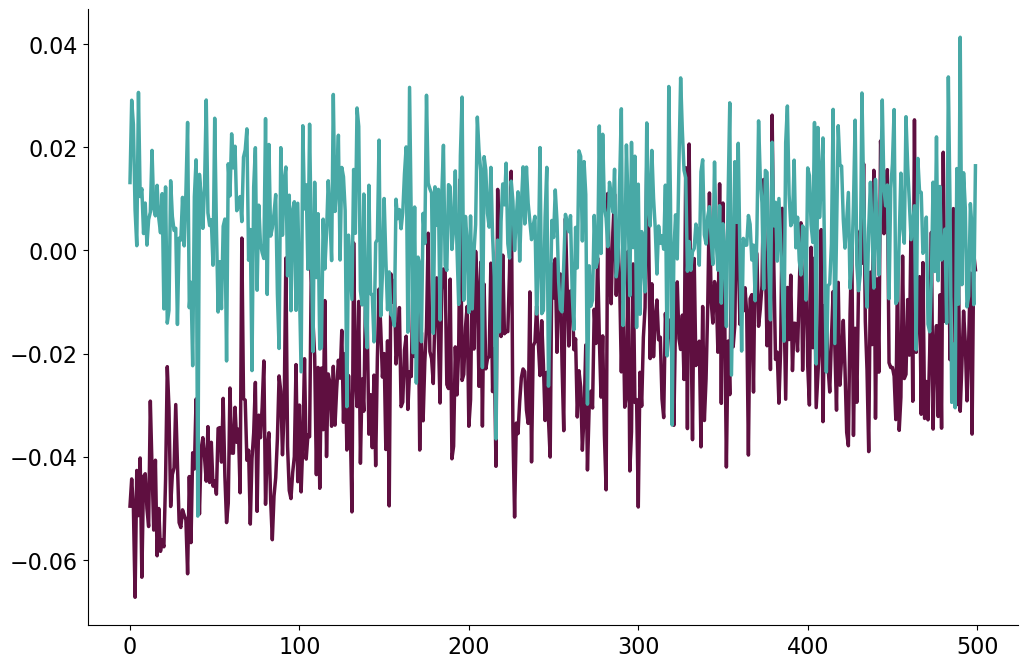

In [171]:
plt.plot(const_0)

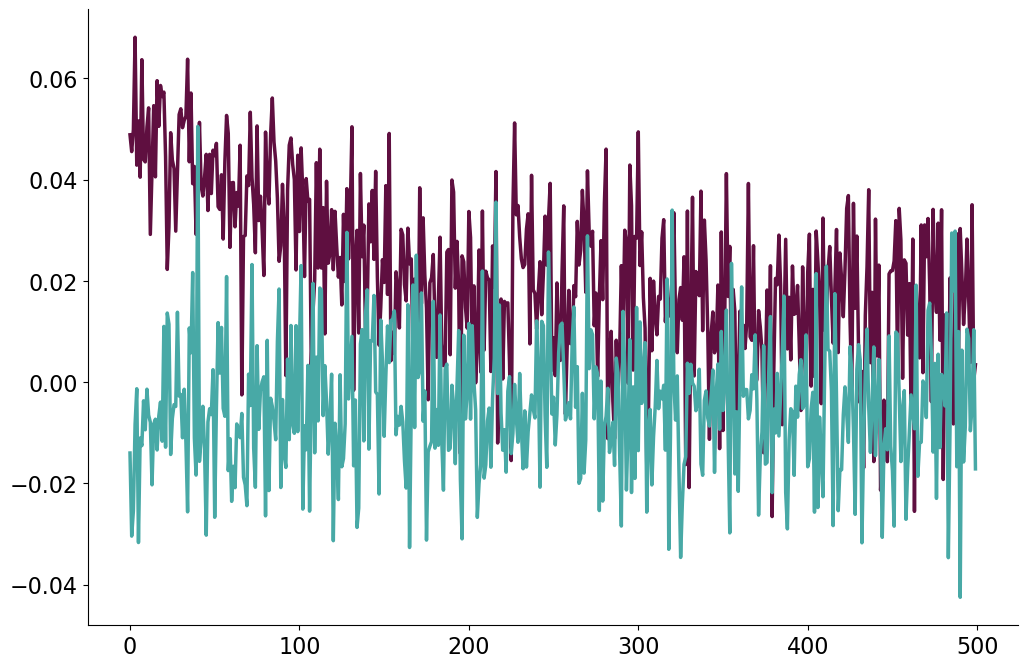

In [172]:
plt.plot(const_1)

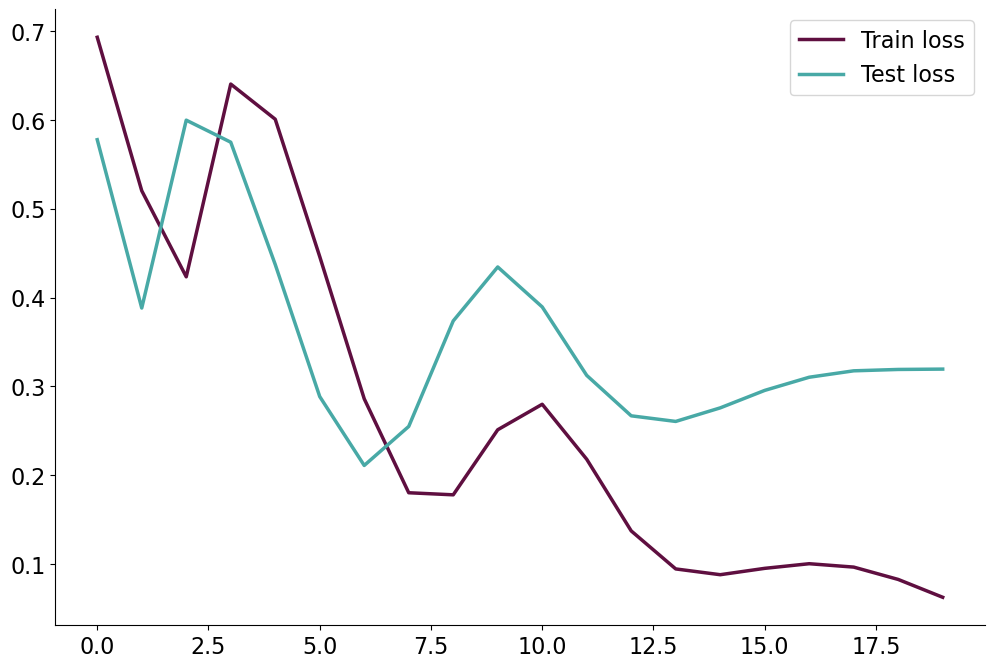

In [173]:
fig, ax = plt.subplots()
ax.plot(log["train_loss"], label = "Train loss")
ax.plot(log["test_loss"], label = "Test loss")
ax.legend()

(array([0.        , 0.0016489 , 0.        , 0.0016489 , 0.00329779,
        0.        , 0.00659559, 0.00989338, 0.00989338, 0.01154228,
        0.01648897, 0.01648897, 0.02638235, 0.04452022, 0.0527647 ,
        0.04616911, 0.04287132, 0.03132904, 0.00989338]),
 array([-24.25439453, -21.23715049, -18.21990646, -15.20266242,
        -12.18541838,  -9.16817434,  -6.1509303 ,  -3.13368627,
         -0.11644223,   2.90080181,   5.91804585,   8.93528988,
         11.95253392,  14.96977796,  17.987022  ,  21.00426604,
         24.02151007,  27.03875411,  30.05599815,  33.07324219]),
 [<matplotlib.patches.Polygon at 0x7fcd28c7b0a0>])

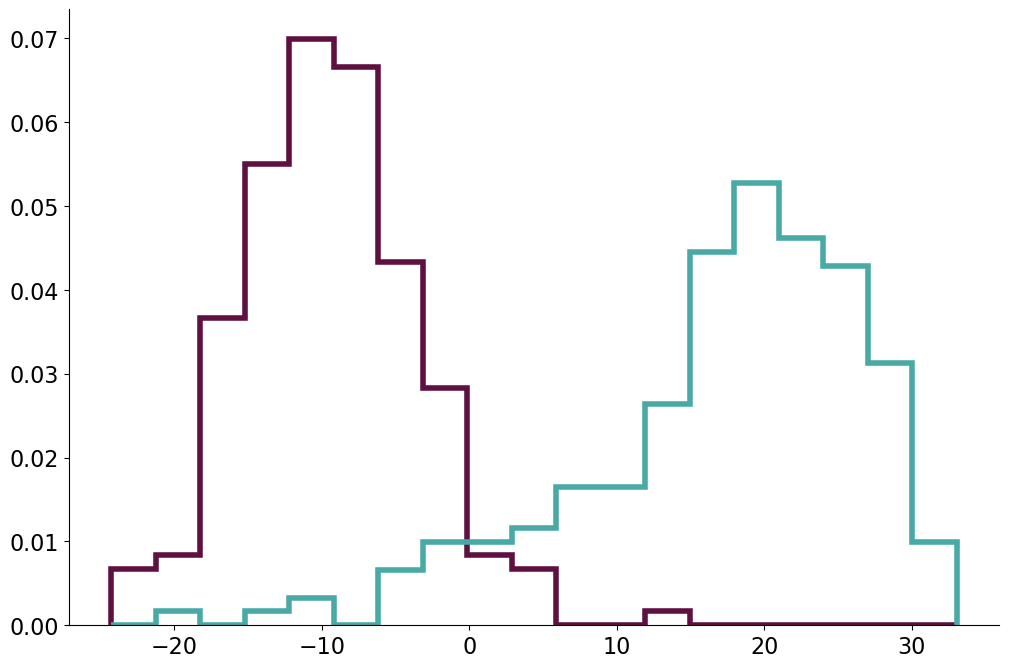

In [174]:
model.train(False)
preds   = model(X_test).detach().numpy()
truth   = y_test.detach().numpy() 
bins = np.linspace(preds.min(), preds.max(), 20)
plt.hist(preds[truth == 0], bins = bins, histtype = "step", linewidth = 4, density = True)
plt.hist(preds[truth == 1], bins = bins, histtype = "step", linewidth = 4, density = True)

In [175]:
roc_auc_score(truth, preds)

0.9769994249856246

In [176]:
plt.plot(list(model.parameters())[0].detach().numpy().reshape(50, 2))

ValueError: cannot reshape array of size 1000 into shape (50,2)